# Wind-driven upwelling - 2 layer analysis

***

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import yaml
import NEMO_upwelling_postprocessing as ps
from matplotlib import colors
from matplotlib.patches import Rectangle
from cmocean import cm
from copy import copy
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.optimize import minimize
from scipy.stats import gaussian_kde
from salishsea_tools import viz_tools
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 14

***

## Load and process results

The processing code can be found in `analysis-ben/modules/NEMO_upwelling_postprocessing.py` and the code development is documented in `analysis-ben/notebooks/SOG_upwelling_paperfigs/NEMO_postprocessing.ipynb`

Functions

In [3]:
def build_idealized_arrays(runs):
    """
    """
    
    # Initialize variables
    arrays = {}
    for key in ['g_prime', 'h_s', 'L_s', 'tau', 'h_u', 'x_u', 'ftW_s', 'j', 'slope', 'N_int', 'U']: arrays[key] = np.empty(0)
    ones = np.ones(sections['n'])
    
    # Wind integration factor
    jtau = (hour - 3) * 3600 * np.sin(np.arctan(2) - sections['angle'])

    # Loop through pycnocline depth and surface layer density
    ftW, h_u, x_u = np.empty(0), np.empty(0), np.empty(0)
    for h_s in param['h_s']:
        for rho_s in param['rho_s']:
            
            # Reduced gravity
            g_prime = const['g'] * (const['rho_0'] - rho_s) / const['rho_0']
            L_s = np.sqrt(g_prime * h_s) / const['f']
            
            # Loop through wind
            for U, tau in zip(param['u_wind'], param['tau']):
                
                arrays['U'] = np.concatenate((arrays['U'], U * ones))

                # Concatenate scale parameters
                arrays['g_prime'] = np.concatenate((arrays['g_prime'], g_prime * ones))
                arrays['h_s'] = np.concatenate((arrays['h_s'], h_s * ones))
                arrays['L_s'] = np.concatenate((arrays['L_s'], L_s * ones))
                arrays['tau'] = np.concatenate((arrays['tau'], tau * jtau))
                
                # Calculate Wedderburn number predictor and observed upwelling/offshore advection
                arrays['N_int'] = np.concatenate((arrays['N_int'], np.array(runs[h_s][rho_s][U]['N_int'])))
                arrays['h_u'] = np.concatenate((arrays['h_u'], np.array(runs[h_s][rho_s][U]['h_u']) / h_s))
                arrays['x_u'] = np.concatenate((arrays['x_u'], np.array(runs[h_s][rho_s][U]['x_u']) / L_s))
                arrays['ftW_s'] = np.concatenate((arrays['ftW_s'], tau * jtau / (const['rho_0'] * h_s * L_s * const['f'])))
                
                # Construct full j and slope arrays
                arrays['j'] = np.concatenate((arrays['j'], sections['ji'][0]))
                arrays['slope'] = np.concatenate((arrays['slope'], sections['slope']))
    
    # Calculate residuals
    x1, x2 = copy(arrays['ftW_s']), copy(arrays['ftW_s']) - 1
    x1[x1 > 1], x2[x2 < 0] = 1, 0
    arrays['h_u_res'] = arrays['h_u'] - x1
    arrays['x_u_res'] = arrays['x_u'] - x2
    arrays = calc_choboter(arrays)
                
    return arrays


def build_hindcast_arrays(runs):
    """
    """

    # Initialize dict
    arrays = {'j': np.empty(0), 'slope': np.empty(0)}
    
    # Calculate Wedderburn number predictor and observed upwelling/offshore advection
    for key1, key2 in zip(['z_h', 'tau', 'z_u', 'x_u', 'N_int'], ['h_s', 'tau', 'h_u', 'x_u', 'N_int']): arrays[key2] = runs[key1].values.flatten()
    arrays['g_prime'] = const['g'] * (const['rho_0'] - runs['rho_s'].values.flatten()) / const['rho_0']
    arrays['L_s'] = np.sqrt(arrays['g_prime'] * arrays['h_s']) / const['f']
    arrays['h_u'] = arrays['h_u'] / arrays['h_s']
    arrays['x_u'] = arrays['x_u'] / arrays['L_s']
    arrays['ftW_s'] = arrays['tau'] / (const['rho_0'] * arrays['h_s'] * arrays['L_s'] * const['f'])
    
    # Construct full j and slope arrays
    for n in range(len(runs.date)):
        arrays['j'] = np.concatenate((arrays['j'], sections['ji'][0]))
        arrays['slope'] = np.concatenate((arrays['slope'], sections['slope']))
    
    # Calculate residuals
    x1, x2 = copy(arrays['ftW_s']), copy(arrays['ftW_s']) - 1
    x1[x1 > 1], x2[x2 < 0] = 1, 0
    arrays['h_u_res'] = arrays['h_u'] - x1
    arrays['x_u_res'] = arrays['x_u'] - x2
    arrays = calc_choboter(arrays)
    
    return arrays


def calc_res(xu, rho_u, mu, T, h_s, dx=0.001):
    """Calculate the area residual between the Ekman flux and the isopycnal displacement
    """
    
    x = np.arange(0, xu + dx, dx)
    A = np.cosh(2 * mu * x) 
    B = np.cos(2 * mu * (1 - x / xu) * rho_u)
    C = np.exp(-mu * T)
    h_a = np.arccos((A+B)/(2*C) - np.sqrt(((A+B)/(2*C))**2 - (A*B+1)/C + 1)) / (2*mu)
    res = np.nansum(h_a) * dx + xu * h_s / const['H'] - T
    
    return abs(res)
    

def calc_choboter(arrays, dx=0.01, xu_max=3):
    """
    """
    
    # Slope array
    xu_range, coarse, fine = [0.3, 2], 0.01, 0.001
    H = const['H']

    # Calculate terms
    N = arrays['N_int'] / H
    L_d = N * H / const['f']
    T = arrays['tau'] / (const['rho_0'] * N * H**2)
    S = arrays['slope'] * arrays['L_s'] / H
    mu = np.arctan(S)
    h_u = np.arccos(1 - 2 * S**2 / (1 + S**2) * (1 - np.exp(-mu * T))) / (2 * mu)
    x_u = []

    # Calculate x_u
    for rho, m, t, h_s in zip(tqdm(h_u), mu, T, arrays['h_s']):
        res = minimize(calc_res, 1, args=(rho, m, t, h_s), bounds=[(0.01, None)])
        x_u.append(float(res.x))
    
    # Result
    arrays['S'] = S
    arrays['L_d'] = L_d
    arrays['h_u_pred'] = h_u
    arrays['x_u_pred'] = np.array(x_u)
    
    return arrays

Load netCDF files and define global parameters

In [4]:
# Load subdomains and sections from YAML
with open('parameters.yaml') as f: grids, events_northerly, events_southerly = yaml.safe_load_all(f)

# Load netCDF results and geo files
HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
grid_HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc')
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')

# Global parameters
const = {'g': 9.81, 'f': 1.11e-4, 'rho_0': 1024, 'H': 200, 'h_s': 10, 'N': 0.001}
hour, e1t, L = 24, 440, 50

# Calculate coastline indices
sections = ps.calc_coastline_indices(mask, bathy.Bathymetry)
sections = ps.calc_coastline_indices_HRDPS(sections, mask, grid_HRDPS)

# Idealized 2-layer results run parameters
param = {
    'u_wind': [5, 10, 15],
    'tau': [0.034, 0.123, 0.280],
    'h_s': [10, 15, 20],
    'rho_s': [1016, 1018, 1020],
}

# Process hindcast results (or load from netCDF)
#runs = ps.process_hindcast_results(events_southerly, sections, mask, HRDPS)
runs_hindcast = xr.open_dataset('/ocean/bmoorema/research/MEOPAR/analysis-ben-hg/notebooks/SOG_upwelling_paperfigs/hindcast_processed.nc')

In [5]:
# Process idealized 2-layer results
runs_idealized = ps.process_idealized_results(param, sections, mask, grids['ideal'], keys=['h_s', 'rho_s', 'u_wind'])

In [6]:
# Build arrays
arrays = {
    'idealized': build_idealized_arrays(runs_idealized),
    'hindcast': build_hindcast_arrays(runs_hindcast),
}

***

## Plot results

Plotting functions

In [16]:
def plot_bathymetry(fig, ax, bathy, tmask):
    """
    """
    
    # Plot landmask and bathymetry
    c = ax.contourf(bathy, cmap='YlGnBu', levels=np.arange(0, 451, 50), extend='max')
    ax.contour(bathy, levels=[200], colors='w')
    ax.contourf(tmask[0, ...], levels=[-0.01, 0.01], colors='lightgray')
    ax.contour(tmask[0, ...], levels=[-0.01, 0.01], colors='k')
    ax.set_xlim([110, 350])
    viz_tools.set_aspect(ax)
    
    return c


def plot_contour(fig, ax, key, arrays, label, std=1, cmap='coolwarm'):
    """Stdev = 1 corresponds to 2.5 km and 0.1 of ft/W (or ~2.5 hours at constant W)
    """
    
    # Interpolate upwelling variable to grid
    xi, yi = np.meshgrid(np.arange(0, 4, 0.1), sections['ji'][0])
    data = gaussian_filter(griddata((arrays['ftW_s'], arrays['j']), arrays[key], (xi, yi), method='nearest'), std)
    
    # Plot interpolated field and original datapoint locations
    c = ax.contourf(xi, yi, data, levels=np.arange(-2.5, 2.6, 0.2), cmap=cmap, extend='both')
    ax.plot(arrays['ftW_s'], arrays['j'], 'ko', markersize=2)
    ax.set_xlim([0, 3.5])
    
    return c


def plot_basic(color='k'):
    """
    """
    
    # Make figure panels
    fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'hspace': 0.1})

    # Loop through models
    k = 0
    for ax, model in zip(axs, arrays):

        # Make plots
        lines = [([0, 1, 4], [0, 1, 1]), ([0, 1, 4], [0, 0, 3])]
        for n, yvar, line, ylabel in zip([1], ['h_u', 'x_u'], lines, ['$h_u/h_s$', '$x_u/L_s$']):
            #c = ax.scatter(
            #    arrays[model]['ftW_s'], arrays[model][yvar],
            #    s=40, c=arrays[model]['S'], vmin=0, vmax=2, cmap='RdBu', edgecolor='k', label='model',
            #)
            ax.plot(arrays[model]['ftW_s'], arrays[model][yvar], 'ko')
            ax.plot(*line, '--', color='magenta', label='predicted', linewidth=2, zorder=10)
            #ax.text(0.02, 0.95, f'({chr(97+k)})', transform=ax.transAxes)
            ax.text(0.83, 0.02, model.capitalize(), transform=ax.transAxes)
            ax.set_xlim([0, 3.5])
            ax.set_ylim([0, 4])
            if model is 'idealized': ax.set_ylabel(ylabel)
            else: ax.yaxis.set_ticklabels('')
            ax.set_xlabel('$t/T_s$')
            k += 1

    # Show legend
    axs[0].legend(loc=1)
    #cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
    #fig.colorbar(c, cax=cax, label='Bottom slope')
    
    return fig, axs


def plot_spatial():
    """
    """
    
    # Make plots and format
    gridspec_kw = {'width_ratios': [2, 2, 0.5, 1.5], 'wspace': 0.1, 'hspace': 0.1}
    text_props = {'facecolor': 'w', 'edgecolor': 'w'}
    fig, axs = plt.subplots(2, 4, figsize=(15, 12), gridspec_kw=gridspec_kw)
    
    # Loop through models
    k = 0
    for row, model in zip(axs, arrays):

        # Interpolate to contour grid and plot results
        labels = ['$h_u/h_s$ residual', '$x_u/L_s$ residual']
        for ax, key, cmap, label, xbar in zip(row[:2], ['h_u', 'x_u'], [cm.curl, cm.delta], labels, [0.145, 0.405]):
            c = plot_contour(fig, ax, key+'_res', arrays[model], label, cmap=cmap)
            ax.text(0.76, 0.03, model.capitalize(), transform=ax.transAxes, bbox=text_props)
            if model is 'hindcast':
                cax = fig.add_axes([xbar, 0.05, 0.2, 0.01])
                fig.colorbar(c, cax=cax, orientation='horizontal', label=label, ticks=range(-3, 4))
        
        # Plot bottom slope and coastline reference
        row[2].plot(sections['slope'], sections['ji'][0], 'k-')
        row[2].set_xlim([0, 0.1])
        c = plot_bathymetry(fig, row[3], bathy.Bathymetry, mask.tmask[0, ...])
            
        # Formatting
        xlabels = ['$ft/W_s$', '$ft/W_s$', 'Bottom slope', 'Grid X']
        for ax, col, xlabel, xpos in zip(row, range(4), xlabels, [0.02, 0.02, 0.1, 0.03]):
            ax.set_ylim([365, 715])
            #ax.text(xpos, 0.95, f'({chr(97+k)})', transform=ax.transAxes, bbox=text_props)
            if col > 0: ax.yaxis.set_ticklabels('')
            else: ax.set_ylabel('Grid Y')
            if model is 'hindcast':
                ax.set_xlabel(xlabel)
                cax = fig.add_axes([0.73, 0.05, 0.17, 0.01])
                fig.colorbar(c, cax=cax, orientation='horizontal', label='Depth [m]', ticks=range(0, 450, 100))
            else: ax.xaxis.set_ticklabels('')
            k += 1

    return fig, axs

***

### Basic plot

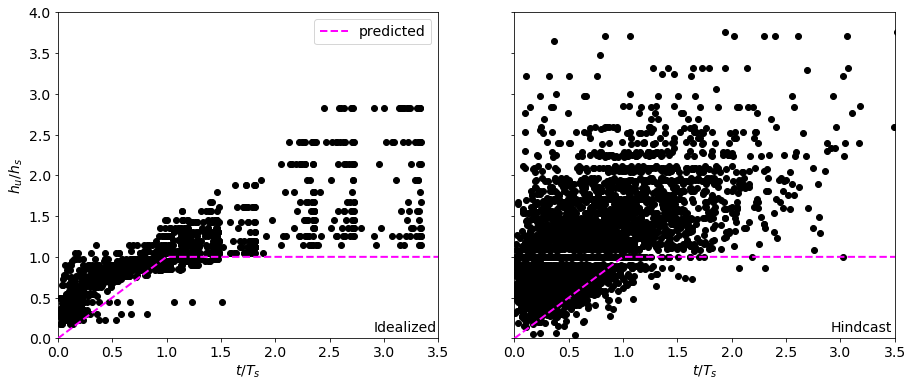

In [18]:
fig, axs = plot_basic()
fig.savefig('/home/bmoorema/Desktop/PPNW2020/slides/figures/basicresults.pdf', bbox_inches='tight')

***

### Spatial dependence

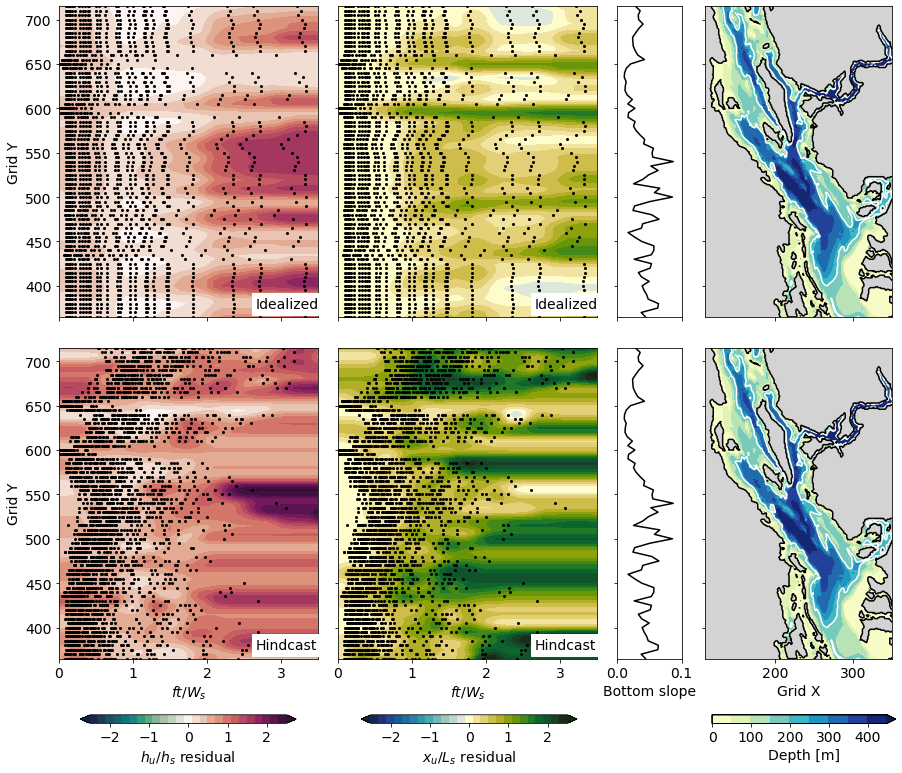

In [14]:
fig, axs = plot_spatial()
#fig.savefig('/home/bmoorema/Desktop/CMOS2020/figs/spatialresults.pdf', bbox_inches='tight')

***

### Choboter et al. 2011

$$\boxed{\hspace{0.5cm}\frac{Z}{H} = -\frac{1}{2\mu}\cos^{-1}\left\{1 - \frac{2S^2}{1 + S^2}\left(1 - e^{-2\mu\frac{ft}{W}}\right)\right\}\hspace{0.5cm}}$$

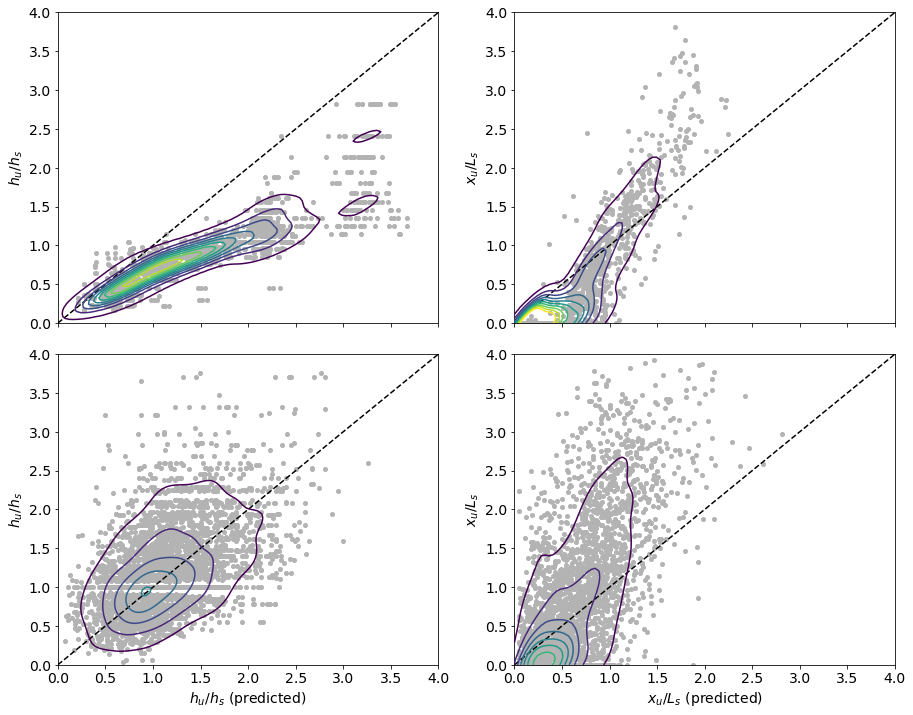

In [216]:
# Make basic plot and return handles
grid = np.linspace(0, 4, 100)
fig, axs = plt.subplots(2, 2, figsize=(15, 12), gridspec_kw={'hspace': 0.1})

for row, model in zip(axs, arrays):

    # Plot results at low and high Burger number
    for ax, key, trans in zip(row, ['h_u', 'x_u'], [const['H']/arrays[model]['h_s'], arrays[model]['L_d']/arrays[model]['L_s']]):
        x, y = arrays[model][key+'_pred']*trans, arrays[model][key]
        ax.plot(x, y, 'o', color=[0.7, 0.7, 0.7], markersize=4)
        kde = gaussian_kde(np.vstack([x, y]))
        Xgrid, Ygrid = np.meshgrid(grid, grid)
        Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))
        ax.contour(Xgrid, Ygrid, Z.reshape(Xgrid.shape), levels=np.arange(0.1, 2.1, 0.2), zorder=10)
                    
    for ax, label in zip(row, ['$h_u/h_s$', '$x_u/L_s$']):
        ax.set_xlim([0, 4])
        ax.set_ylim([0, 4])
        ax.plot([0, 4], [0, 4], 'k--')
        ax.set_ylabel(label)
        if model == 'hindcast': ax.set_xlabel(label + ' (predicted)')
        else: ax.xaxis.set_ticklabels('')

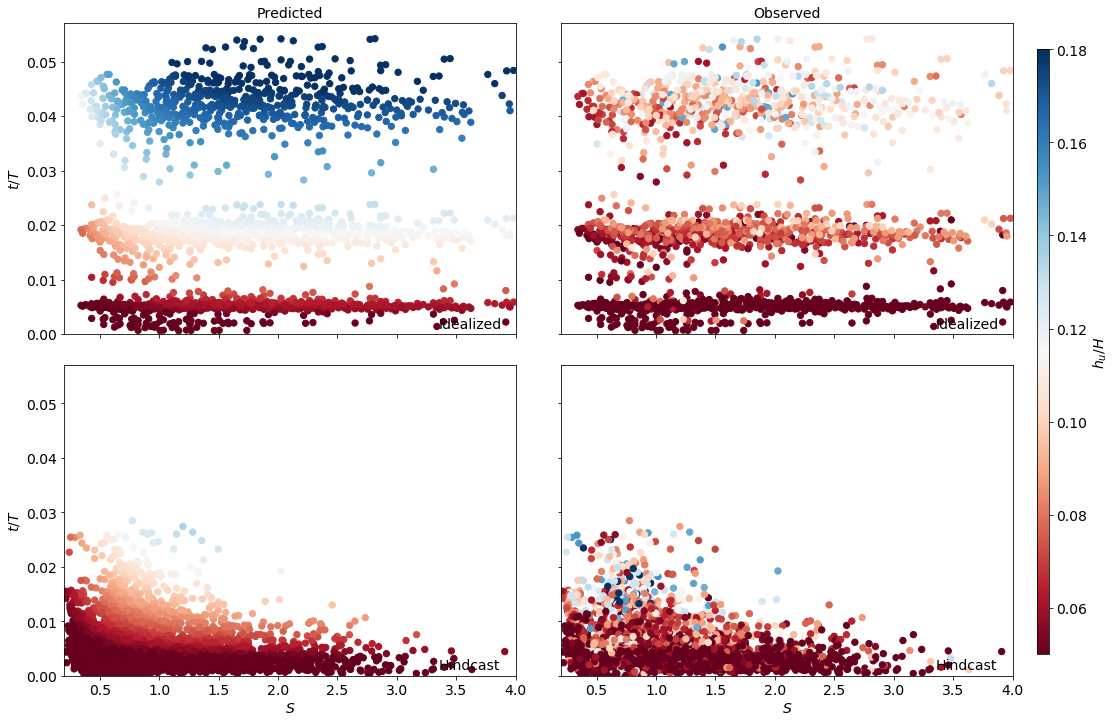

In [108]:
# Make basic plot and return handles
model = 'idealized'
fig, axs = plt.subplots(2, 2, figsize=(17, 12), gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

for row, model in zip(axs, arrays):
    
    row[0].set_ylabel('$t/T$')
    row[1].yaxis.set_ticklabels('')

    for ax, tag, label, transform in zip(row, ['_pred', ''], ['Predicted', 'Observed'], [1, arrays[model]['h_s'] / (const['H'] - arrays[model]['h_s'])]):
        ax.set_xlim([0.2, 4])
        ax.set_ylim([0, 0.057])
        ax.text(0.83, 0.02, model.capitalize(), transform=ax.transAxes)
        if model == 'idealized':
            ax.set_title(label, size=14)
            ax.xaxis.set_ticklabels('')
        else: ax.set_xlabel('$S$')

        # Plot results at low and high Burger number
        T = arrays[model]['tau'] / (const['rho_0'] * arrays[model]['N_int'] * (const['H'] - arrays[model]['h_s']))
        c = ax.scatter(arrays[model]['S'], T, s=40, c=arrays[model]['h_u'+tag]*transform, vmin=0.05, vmax=0.18, cmap='RdBu')
    
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(c, cax=cax, label='$h_u/H$')

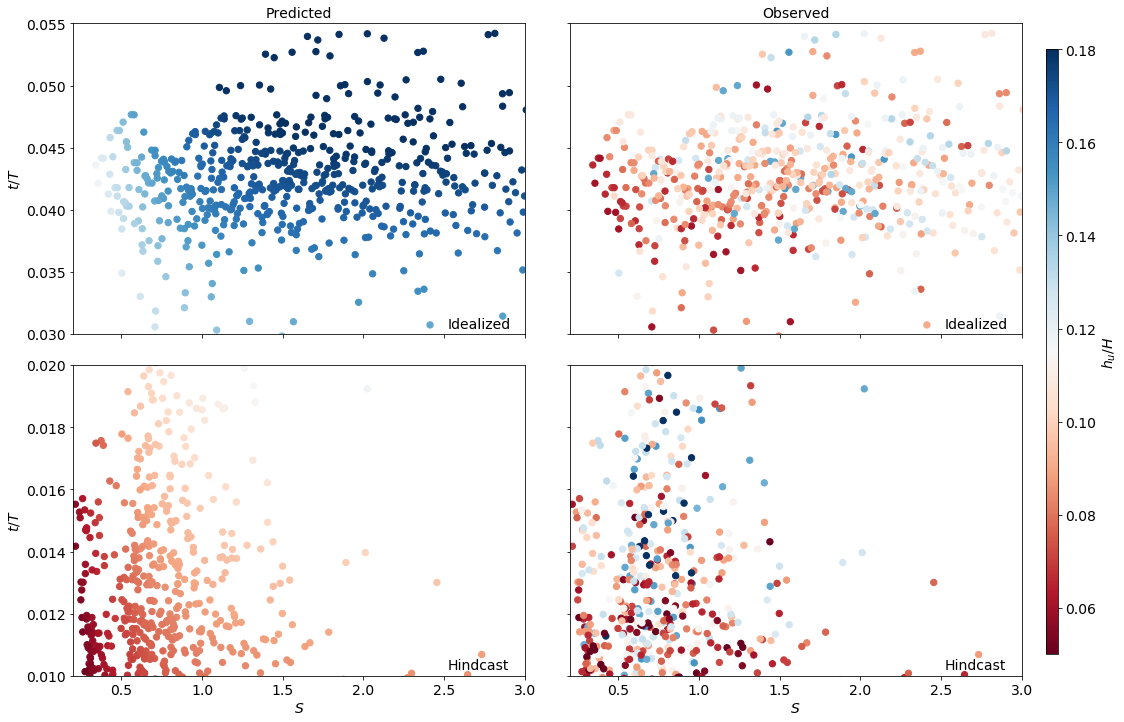

In [109]:
# Make basic plot and return handles
model = 'idealized'
fig, axs = plt.subplots(2, 2, figsize=(17, 12), gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

for row, model, ylim in zip(axs, arrays, [[0.03, 0.055], [0.01, 0.02]]):
    
    row[0].set_ylabel('$t/T$')
    row[1].yaxis.set_ticklabels('')

    for ax, tag, label, transform in zip(row, ['_pred', ''], ['Predicted', 'Observed'], [1, arrays[model]['h_s'] / (const['H'] - arrays[model]['h_s'])]):
        ax.set_xlim([0.2, 3])
        ax.set_ylim(ylim)
        ax.text(0.83, 0.02, model.capitalize(), transform=ax.transAxes)
        if model == 'idealized':
            ax.set_title(label, size=14)
            ax.xaxis.set_ticklabels('')
        else: ax.set_xlabel('$S$')

        # Plot results at low and high Burger number
        T = arrays[model]['tau'] / (const['rho_0'] * arrays[model]['N_int'] * (const['H'] - arrays[model]['h_s']))
        c = ax.scatter(arrays[model]['S'], T, s=40, c=arrays[model]['h_u'+tag]*transform, vmin=0.05, vmax=0.18, cmap='RdBu')
    
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(c, cax=cax, label='$h_u/H$')

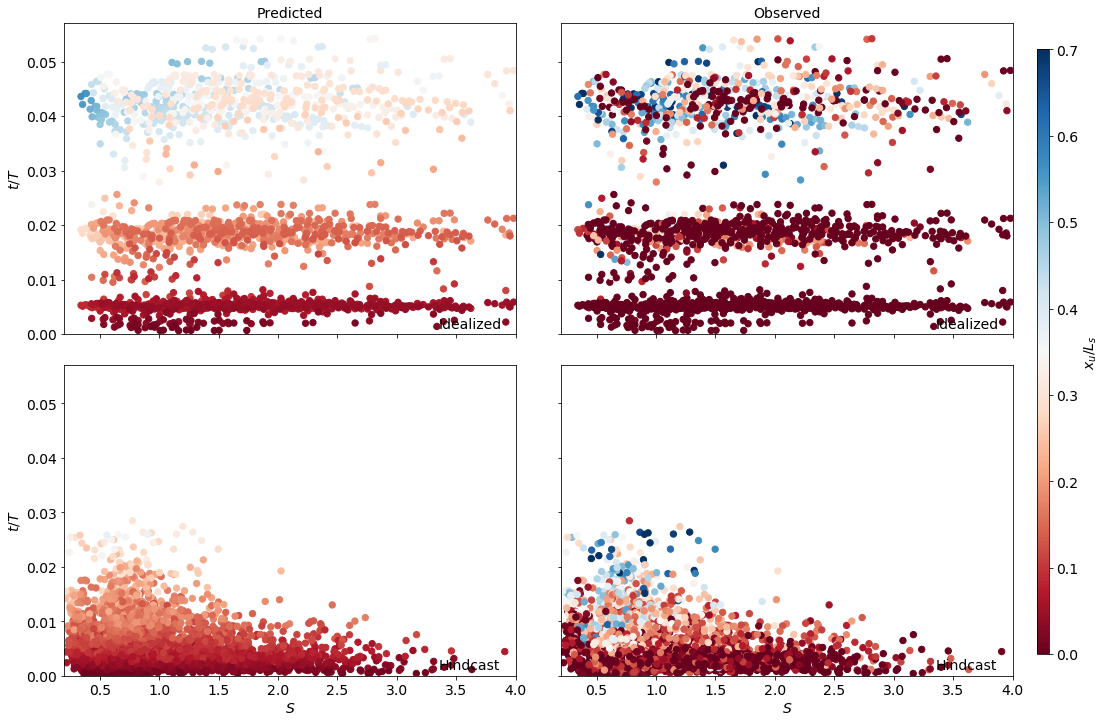

In [145]:
# Make basic plot and return handles
model = 'idealized'
fig, axs = plt.subplots(2, 2, figsize=(17, 12), gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

for row, model in zip(axs, arrays):
    
    row[0].set_ylabel('$t/T$')
    row[1].yaxis.set_ticklabels('')

    for ax, tag, label, transform in zip(row, ['_pred', ''], ['Predicted', 'Observed'], [1, arrays[model]['L_s'] / arrays[model]['L_d']]):
        ax.set_xlim([0.2, 4])
        ax.set_ylim([0, 0.057])
        ax.text(0.83, 0.02, model.capitalize(), transform=ax.transAxes)
        if model == 'idealized':
            ax.set_title(label, size=14)
            ax.xaxis.set_ticklabels('')
        else: ax.set_xlabel('$S$')

        # Plot results at low and high Burger number
        T = arrays[model]['tau'] / (const['rho_0'] * arrays[model]['N_int'] * (const['H'] - arrays[model]['h_s']))
        c = ax.scatter(arrays[model]['S'], T, s=40, c=arrays[model]['x_u'+tag]*transform, vmin=0, vmax=0.7, cmap='RdBu')
    
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(c, cax=cax, label='$x_u/L_s$')

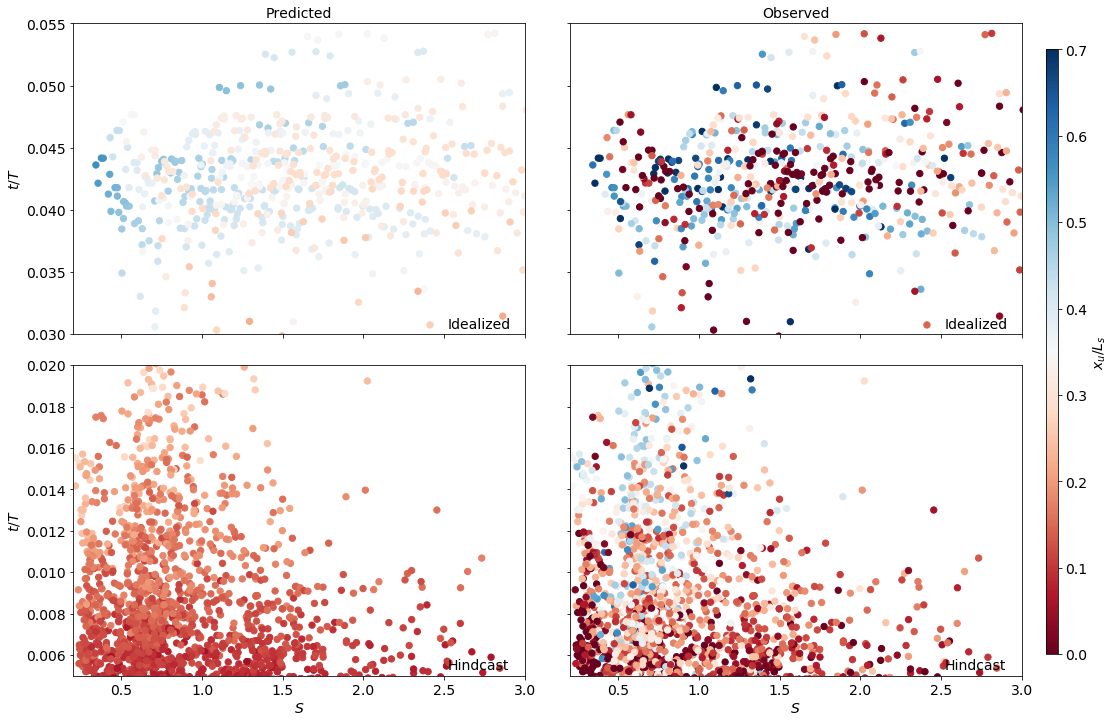

In [144]:
# Make basic plot and return handles
model = 'idealized'
fig, axs = plt.subplots(2, 2, figsize=(17, 12), gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

for row, model, ylim in zip(axs, arrays, [[0.03, 0.055], [0.005, 0.02]]):
    
    row[0].set_ylabel('$t/T$')
    row[1].yaxis.set_ticklabels('')

    for ax, tag, label, transform in zip(row, ['_pred', ''], ['Predicted', 'Observed'], [1, arrays[model]['L_s'] / arrays[model]['L_d']]):
        ax.set_xlim([0.2, 3])
        ax.set_ylim(ylim)
        ax.text(0.83, 0.02, model.capitalize(), transform=ax.transAxes)
        if model == 'idealized':
            ax.set_title(label, size=14)
            ax.xaxis.set_ticklabels('')
        else: ax.set_xlabel('$S$')

        # Plot results at low and high Burger number
        T = arrays[model]['tau'] / (const['rho_0'] * arrays[model]['N_int'] * (const['H'] - arrays[model]['h_s']))
        c = ax.scatter(arrays[model]['S'], T, s=40, c=arrays[model]['x_u'+tag]*transform, vmin=0, vmax=0.7, cmap='RdBu')
    
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(c, cax=cax, label='$x_u/L_s$')